# MP2: Deep Fast Fashion

Date: 2020.11.22

Author: © 2020 Dovilė Komolovaitė

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

The goal of this work is to create a deep learning model using [PyTorch](https://pytorch.org/), that is trained in under 3 minutes in [Google Colab](https://colab.research.google.com/) environment on [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) data, gives the best possible testing performance. 

This template is partially based on [this solution](
https://medium.com/dair-ai/pytorch-1-2-quickstart-with-google-colab-6690a30c38d). 

You should select GPU in Google Colab: *Runtime -> Change runtime type -> Hardware accelerator: GPU*.

The performance will be measured on *Tesla P100* graphics card which is the most popular in Google Colab machines, but you will not always get a machine with this GPU. Other GPUs: Tesla P4, Tesla T4 are similar in performance to P100 (slightly faster on average), and K80 is slower. The speed also varies slightly based on other factors, like the Colab cloud usage load.

You should only eddit this notebook where it is allowed, comment on all of your improvements in markdown cells and in your presentation.

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import numpy as np

## Settings

Do not eddit!

On the reproducibility of experiments: https://pytorch.org/docs/stable/notes/randomness.html

In [94]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 1.0*corrects / batch_size
    return accuracy.item()
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Information on the obtained hardware

In [95]:
print('Torch version: %s' %torch.__version__)
if torch.cuda.is_available():
    print('GPU: %s' %torch.cuda.get_device_name()) 
else:
    print('GPU not available.')

Torch version: 1.7.0+cu101
GPU: Tesla T4


In [96]:
!nvidia-smi

Sun Nov 22 08:59:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    31W /  70W |   1211MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [97]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.000
BogoMIPS:            4400.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

## Import the data

You can change the data transformations but not the splitting (50000:10000) between training and validation in this notebook. But you can use a different type of validation with this data in our other codes to find the best model and its hyper-parameters, as long as you don't touch testing data. 

In [98]:
BATCH_SIZE = 32

# transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
# do not change this!
dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainset, validset = torch.utils.data.random_split(dataset, [50000,10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

len(trainset), len(validset) # 83% training, 17% testing

(50000, 10000)

### Show a couple of data points

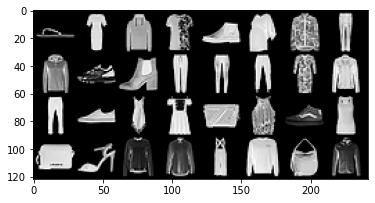

In [99]:
import matplotlib.pyplot as plt

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

## Report of the things tried and their validation results

Replace the content of this cell with your short report on the different validation schemes, architectures, options for the layers, learning hyper parameters you tried and the results you got (training/validation error/accuracy). Give links to code / articles / posts you took ideas from. The code for these different ideas comes not here, but in a separate zip file.

The results can be presented in Tables like this:

|        Model        | Training accuracy | Validation accuracy |
|---------------------|-------------------|---------------------|
| initial given model |      0.9549       |       0.9070        |
|   LeNet   |      0.9426        |      0.9100          |
| LeNet5 |       0.9300       |       0.9036         |
| My final model |      0.9672        |      0.9415         |

More on formatting markdown: https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet

## Create the best model

You can go wild here!

Give a short description of what you are doing here. 

In [100]:
print(f'We have {images.shape[0]} images in each batch, which has {images.shape[1]} color channel and {images.shape[2]}x{images.shape[3]} pixel dimensions.')
print(f'We have {labels.shape[0]} labels.')

We have 32 images in each batch, which has 1 color channel and 28x28 pixel dimensions.
We have 32 labels.


The model was developed through multiple trials and tests. 
The best performance was achieved as follows.

**This is a Multi-Layer Neural Network.**
 - In each layer, 2D convolution is performed with a set number of in_channels and out_channels.
 - All hidden layers have Batch Normalization.
 - The Sigmoid function performed best for the activation function.
 - In the last step, the 2D max pooling is applied to obtain a smaller tensor and a control overfitting.

 

Finally, a function classifier was developed. Here I do the following:
   - Pass data through Dropout to get zeroed random items. This helps with regularization.
   - Apply a linear transformation.
   - Apply batch normalization.
   - Apply the Sigmoid function.
   - Dropout some elements again.
   - Apply the Softmax function to all columns.
   - And apply a linear transformation to get fewer output features.

In [101]:
class MyModel(nn.Module):
  # Multi-Layer Neural Network:
    def __init__(self):
        super(MyModel, self).__init__()

        self.layer_seq1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.Sigmoid()
        )
        self.layer_seq2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer_seq3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer_seq4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier_layer = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.Linear(256 * 3 * 3, 128),
            nn.BatchNorm1d(128),
            nn.Sigmoid(),
            nn.Dropout(p=0.25),
            nn.Softmax(dim=1),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.layer_seq1(x)
        x = self.layer_seq2(x)
        x = self.layer_seq3(x)
        x = self.layer_seq4(x)
        out = x.view(x.size(0), -1)
        out = self.classifier_layer(out)
        return out

### Learning parameters

You have a freedom here. But the model should stay the `model`. And the `num_epochs` should be such that training should not exceed 3 minutes on Tesla T100.

I wrote an adjusted learning rate function here. This function recalculates the learning rate in each epoch. This is important because too large learning rate might lead to local optimum, and too small may result in a long training process.

In [102]:
def adjust_learning_rate(optimizer, epoch):
    lr = 0.01

    if epoch > 6:
        lr = lr / 10
    elif epoch > 5:
        lr = lr / 25
    elif epoch > 3:
        lr = lr / 2

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [103]:
learning_rate = 0.01
num_epochs = 10 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train

Do not edit! The training is only happening here.

In [104]:
# timing. do not alter!
start_timer = torch.cuda.Event(enable_timing=True)
end_timer = torch.cuda.Event(enable_timing=True)
start_timer.record()

# training stats
trainlosses = np.zeros(num_epochs)
trainaccs = np.zeros(num_epochs)
validaccs = np.zeros(num_epochs)

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)

    # the learning rate adjustment function (updated)
    adjust_learning_rate(optimizer, epoch)

    model.eval()
    train_running_loss /= len(trainloader)
    train_acc /= len(trainloader)

    valid_acc = 0.0
    for i, (images, labels) in enumerate(validloader, 0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        valid_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    
    valid_acc /= len(validloader)
    print(f'learning rate: {optimizer.param_groups[0]["lr"]}')
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.4f | Validation Accuracy: %.4f' \
          %(epoch, train_running_loss, train_acc, valid_acc)) 
            
    trainlosses[epoch] = train_running_loss
    trainaccs[epoch] = train_acc
    validaccs[epoch] = valid_acc

# timing. do not alter!
end_timer.record()
torch.cuda.synchronize()
elapsed_time = start_timer.elapsed_time(end_timer)
max_training_time = 3*60*1000
print('Training time: %.2f ms (max %i ms.)' %(elapsed_time,max_training_time))  
assert elapsed_time <= max_training_time, 'Training is too long!'

learning rate: 0.01
Epoch: 0 | Loss: 1.2604 | Train Accuracy: 0.7102 | Validation Accuracy: 0.8208
learning rate: 0.01
Epoch: 1 | Loss: 0.5596 | Train Accuracy: 0.8672 | Validation Accuracy: 0.8955
learning rate: 0.01
Epoch: 2 | Loss: 0.3556 | Train Accuracy: 0.9060 | Validation Accuracy: 0.9133
learning rate: 0.01
Epoch: 3 | Loss: 0.2716 | Train Accuracy: 0.9202 | Validation Accuracy: 0.9265
learning rate: 0.005
Epoch: 4 | Loss: 0.2248 | Train Accuracy: 0.9303 | Validation Accuracy: 0.9287
learning rate: 0.005
Epoch: 5 | Loss: 0.1807 | Train Accuracy: 0.9451 | Validation Accuracy: 0.9346
learning rate: 0.0004
Epoch: 6 | Loss: 0.1584 | Train Accuracy: 0.9516 | Validation Accuracy: 0.9345
learning rate: 0.001
Epoch: 7 | Loss: 0.1315 | Train Accuracy: 0.9619 | Validation Accuracy: 0.9394
learning rate: 0.001
Epoch: 8 | Loss: 0.1251 | Train Accuracy: 0.9643 | Validation Accuracy: 0.9402
learning rate: 0.001
Epoch: 9 | Loss: 0.1182 | Train Accuracy: 0.9672 | Validation Accuracy: 0.9415
Tra

Plot training loss, training and validation accuracy over training epochs.

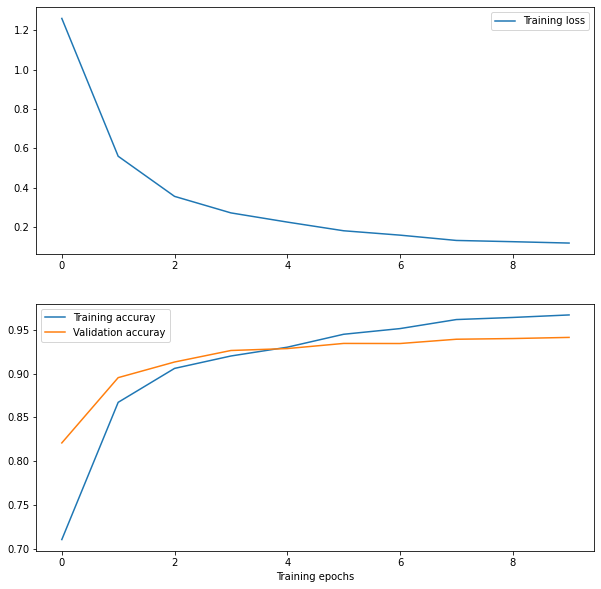

In [105]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(trainlosses)
plt.legend(['Training loss']) 
plt.subplot(2,1,2)
plt.plot(trainaccs)
plt.plot(validaccs)
plt.xlabel('Training epochs')
plt.legend(['Training accuray','Validation accuray'])

In [106]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
           Sigmoid-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          18,496
       BatchNorm2d-5           [-1, 64, 28, 28]             128
           Sigmoid-6           [-1, 64, 28, 28]               0
         MaxPool2d-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]          73,856
       BatchNorm2d-9          [-1, 128, 14, 14]             256
          Sigmoid-10          [-1, 128, 14, 14]               0
        MaxPool2d-11            [-1, 128, 7, 7]               0
           Conv2d-12            [-1, 256, 7, 7]         295,168
      BatchNorm2d-13            [-1, 256, 7, 7]             512
          Sigmoid-14            [-1, 25